In [1]:
import gym_causal
import numpy as np
import matplotlib.pyplot as plt
import gym
import networkx as nx
import random
import scipy.special as spc

In [7]:
class Agent(object):
    """
    Causal Agent
    """
    def __init__(self, act_space, obs_space, rew_space):
        
        self.action_space = act_space
        self.observation_space = obs_space
        self.reward_space = rew_space
        self.time = 0
        self.occ_table = np.zeros([len(rew_space),
                           len(self.action_space),
                           len(self.observation_space)])
        self.G = self.create_graph()
        self.memory = np.zeros((1, 4))
        
    def create_graph(self):
        """
        Init the causal graph
        
        """
        
        G = nx.DiGraph()
        
        for i in range(len(self.observation_space)):
            node_name = "obs" + str(i)
            G.add_node(node_name)
        for i in range(len(self.action_space)):
            node_name = "act" + str(i)
            G.add_node(node_name)
        for i in range(len(self.reward_space)):
            node_name = "rew" + str(i)
            G.add_node(node_name)
            
        return G

    def act(self, temp):
        
        if (self.time == 0):
            action = random.choice(self.action_space)
        else:
            probs = np.exp(agent.occ_table[1:].sum(axis=0)/temp) / np.sum(np.exp(agent.occ_table[1:].sum(axis=0)/temp))
            cumul = 0
            choice = random.uniform(0, 1)
            for a, pr in enumerate(probs[:, 1]):
                cumul += pr
                if cumul > choice:
                    action = a  
                else: 
                    action = random.choice(self.action_space)                  
        self.time += 1

        return action
    

        
    def update_memory(self, act, obs, rew, done):
        
        self.memory = np.append(self.memory, np.array([[act, obs, rew, done]]), axis = 0)   

        # first get the nodes corresponding to last action/ob/rew
        action_node = "act" + str(np.where(act == self.action_space)[0][0])
        obs_node = "obs" + str(np.where(obs == self.observation_space)[0][0])
        rew_node = "rew" + str(np.where(rew == self.reward_space)[0][0])
        
        # check if the edges already exist to update the weights
        if ((action_node, obs_node) in self.G.edges):
            act_obs_weight = self.G[action_node][obs_node]['weight']
        else: 
             act_obs_weight = 1
        
        if ((action_node, rew_node) in self.G.edges):
            act_rew_weight = self.G[action_node][rew_node]['weight']
        else:
            act_rew_weight = 1
        
        if ((obs_node, rew_node) in self.G.edges):
            obs_rew_weight = self.G[obs_node][rew_node]['weight']
        else:
            obs_rew_weight = 1
            
        # then draw edges from action to (obs and rew) nodes
        self.G.add_edge(action_node, obs_node, weight = act_obs_weight + 1)
        self.G.add_edge(action_node, rew_node, weight = act_rew_weight + 1)
        self.G.add_edge(obs_node, rew_node, weight = obs_rew_weight + 1)
        
        # update co occurence table 
        i = (np.where(rew == self.reward_space)[0][0])
        j = (np.where(act == self.action_space)[0][0])
        k = (np.where(obs == self.observation_space)[0][0])
        self.occ_table[i][j][k] += 1
        

class randomAgent(object):
    """
    Random agent
    """
    def __init__(self,
                 action_space,
                 observation_space,
                 reward_space):
        
        self.action_space = action_space
        self.observation_space = observation_space
        self.reward_space = reward_space
        self.time = 0

        
    def act(self):
    
        action = random.choice(self.action_space)    
        self.time += 1
       
        return action
    

The following code is intended for the specific Volleyball task

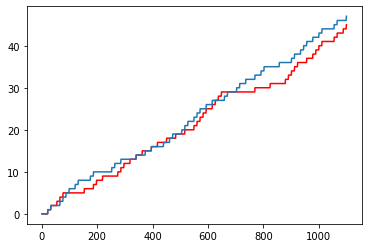

In [8]:
# PARAMETERS
different_probs = np.array([[0.8, 0.2],
                            [0.5, 0.5],
                            [0.2, 0.8], 
                            [1, 0], 
                            [0, 1]])
different_probs = np.array([[0.5, 0.5],
                            [0.5, 0.5],
                            [0.2, 0.8], 
                            [1, 0], 
                            [0, 1]])
list_rewards = []
episode_count = 100 # total number of game is episode_count*10 or 11?
# for the plot
x = np.arange(1, episode_count*11+1, 1)

for j in range(len(different_probs)-4):
    # INIT PARAMETERS
    probs1, probs2 = different_probs[j]
    reward = 0
    done = False
    temp = 1000000
    #INIT ENV
    env = gym.make('gym_causal:causal-v0')
    env.reset()
    env.set_probs(probs1, probs2)
    env.set_rewards(np.array([0, 1]))
    
    #CREATE AGENT
    agent = Agent(env.action_space,
                  env.observation_space, 
                  env.reward_space)
    
    # INIT REWARD RECORD
    rewards = np.zeros(episode_count*11)
    total_reward = 0
    
    #random agent
    randenv = gym.make('gym_causal:causal-v0')
    randenv.reset()
    randenv.set_probs(probs1, probs2)
    randenv.set_rewards(np.array([0, 1]))
    
    randag = randomAgent(env.action_space,
                  env.observation_space, 
                  env.reward_space)
    randrewards = np.zeros(episode_count*11)
    randtotal_reward = 0

    j = 0
    l = 0
    for i in range(1, episode_count+1):
        # RESET BEFORE EPISODE
        env.reset()
        randenv.reset()
        done = False
        
        while not done: 
            # Causal agent
            temp *= 0.99

            action = agent.act(temp)
            ob, reward, done, _ = env.step(action)
    
            # update agent memory & causal graph
            agent.update_memory(action, ob, reward, done)
            
            total_reward += reward
            rewards[j] = total_reward

            j += 1
            
            
        done = False
  
        while not done: 
            # random agent
            action = randag.act()
            ob, reward, done, _ = randenv.step(action)
            #print(reward)
            #print(randenv.time)
            randtotal_reward += reward
            #print(randtotal_reward)
            randrewards[l] = randtotal_reward

            l += 1
   

    list_rewards.append(rewards)
    
    plt.plot(x, rewards, color='r')
    plt.plot(x, randrewards)
        
    env.close()
    randenv.close()

In [ ]:
nx.draw_shell(agent.G, with_labels=True)

In [4]:
env

In [5]:
env.reward_space


array([0, 1])